In [1]:
import numpy as np
from astropy.io import fits
from scipy.ndimage import rotate
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
import aplpy
from matplotlib.patches import Rectangle
from astropy.visualization import (MinMaxInterval, AsinhStretch)
from astropy.wcs import WCS
from astropy.visualization import wcsaxes
from astropy import units as u
import pandas as pd
from astropy.table import Table, hstack
from astropy.table import join
import os

In [2]:
# Spectra VLT
df_spec = pd.read_csv("../flux-around-halpha.csv")

In [3]:
# Convert Pandas DataFrame 'df' to Astropy Table
table_spc = Table.from_pandas(df_spec)
table_spc

Extension Name,Wavelengths within Range,Fluxes within Range,Mean Wavelengths,Sum Fluxes
str10,str78,str95,float64,float64
SMC-SMP-1,"(6553.0637408641605, 6567.821537038354, 6583.128152918056, 6588.4660231033195)","(1.2022578610051685e-14, 5.494703046298636e-13, 2.0085540155717734e-15, 3.691481308740477e-14)",6573.1198634809725,6.004162503428919e-13
SMC-SMP-2,"(6553.51000174078, 6565.416766635332, 6568.098328576803, 6588.870482626433)","(5.462622213390637e-15, -4.161905026811382e-10, 5.189952591446627e-13, 1.6700709365007887e-14)",6568.973894894837,-4.1564934409041507e-10
SMC-SMP-8,"(6552.788925756808, 6567.364336480378, 6588.1210922735345)","(1.1403752283280212e-15, 4.791529148326006e-13, 4.9753043240508554e-15)",6569.424784836906,4.852685943849796e-13
SMC-SMP-13,"(6553.400605080448, 6568.11135794641, 6583.508330534921, 6588.757061695615)","(7.68697740521025e-15, 8.259523934973338e-13, 1.1442484193870092e-15, 2.4185176866156056e-14)",6573.444338814348,8.589687961880871e-13
SMC-SMP-18,"(6552.770059305075, 6567.507477808056, 6582.791745453975, 6588.16608676816)","(1.5436682368707992e-14, 7.252845636297283e-13, 1.4039282146352237e-15, 4.869836831659918e-14)",6572.808842333817,7.908235425296707e-13
SMC-SMP-20,"(6552.103504840201, 6566.849310471623, 6582.101266014918, 6587.433940947145)","(3.756015626893724e-15, 1.1170046716796211e-12, 2.5149286739753887e-15, 1.0937016980395785e-14)",6572.122005568472,1.134212632960886e-12
SMC-SMP-24,"(6552.888838775578, 6567.652267536342, 6588.287220289874)","(1.2841874899416144e-14, 6.396599150665972e-13, 3.956243979083235e-14)",6569.609442200599,6.920642297568457e-13
SMC-SMP-25,"(6552.980160567651, 6565.102701166069, 6567.854215925305, 6588.4048817585635)","(8.506910043029823e-15, -6.46469115250165e-11, 1.755231550465073e-13, 2.62826542886605e-14)",6568.585489854398,-6.443659880563831e-11


In [4]:
# Spectra VLT
table_img = Table.read("../flux-pseudoslit-halpha.ecsv", format="ascii.ecsv")

In [5]:
table_img

ID,Name spec,Flux_slit
str21,str10,float64
iDR4_3_MC0113_0054489,SMC-SMP-1,5.72037642948553e-13
iDR4_3_MC0093_0237121,SMC-SMP-2,5.614099137830897e-13
iDR4_3_MC0115_1053289,SMC-SMP-13,8.170497698550827e-13
iDR4_3_MC0115_0671498,SMC-SMP-18,7.686082673097339e-13
iDR4_3_MC0048_0001615,SMC-SMP-20,1.0613599842751453e-12
iDR4_3_MC0094_0183910,SMC-SMP-24,7.005829293429966e-13
iDR4_3_MC0094_0213041,SMC-SMP-25,2.0389571107892746e-13


In [6]:
# Renaming the columns in table_spc to match table_img
table_spc.rename_column('Extension Name', 'ID')
table_img.rename_column('Name spec', 'FileID')
table_img["FileID"]

SMC-SMP-1
SMC-SMP-2
SMC-SMP-13
SMC-SMP-18
SMC-SMP-20
SMC-SMP-24
SMC-SMP-25


In [7]:
# Convert Astropy tables to Pandas DataFrames
df1 = table_spc.to_pandas()
df2 = table_img.to_pandas()

In [8]:
df1

,ID,Wavelengths within Range,Fluxes within Range,Mean Wavelengths,Sum Fluxes
0,SMC-SMP-1,"(6553.0637408641605, 6567.821537038354, 6583.1...","(1.2022578610051685e-14, 5.494703046298636e-13...",6573.119863,6.004163e-13
1,SMC-SMP-2,"(6553.51000174078, 6565.416766635332, 6568.098...","(5.462622213390637e-15, -4.161905026811382e-10...",6568.973895,-4.156493e-10
2,SMC-SMP-8,"(6552.788925756808, 6567.364336480378, 6588.12...","(1.1403752283280212e-15, 4.791529148326006e-13...",6569.424785,4.852686e-13
3,SMC-SMP-13,"(6553.400605080448, 6568.11135794641, 6583.508...","(7.68697740521025e-15, 8.259523934973338e-13, ...",6573.444339,8.589688e-13
4,SMC-SMP-18,"(6552.770059305075, 6567.507477808056, 6582.79...","(1.5436682368707992e-14, 7.252845636297283e-13...",6572.808842,7.908235e-13
5,SMC-SMP-20,"(6552.103504840201, 6566.849310471623, 6582.10...","(3.756015626893724e-15, 1.1170046716796211e-12...",6572.122006,1.134213e-12
6,SMC-SMP-24,"(6552.888838775578, 6567.652267536342, 6588.28...","(1.2841874899416144e-14, 6.396599150665972e-13...",6569.609442,6.920642e-13
7,SMC-SMP-25,"(6552.980160567651, 6565.102701166069, 6567.85...","(8.506910043029823e-15, -6.46469115250165e-11,...",6568.585490,-6.443660e-11


In [9]:
# Merge DataFrames on common columns
merged_df = pd.merge(df1, df2, left_on='ID', right_on='FileID', how='inner')

In [10]:
merged_df

,ID_x,Wavelengths within Range,Fluxes within Range,Mean Wavelengths,Sum Fluxes,ID_y,FileID,Flux_slit
0,SMC-SMP-1,"(6553.0637408641605, 6567.821537038354, 6583.1...","(1.2022578610051685e-14, 5.494703046298636e-13...",6573.119863,6.004163e-13,iDR4_3_MC0113_0054489,SMC-SMP-1,5.720376e-13
1,SMC-SMP-2,"(6553.51000174078, 6565.416766635332, 6568.098...","(5.462622213390637e-15, -4.161905026811382e-10...",6568.973895,-4.156493e-10,iDR4_3_MC0093_0237121,SMC-SMP-2,5.614099e-13
2,SMC-SMP-13,"(6553.400605080448, 6568.11135794641, 6583.508...","(7.68697740521025e-15, 8.259523934973338e-13, ...",6573.444339,8.589688e-13,iDR4_3_MC0115_1053289,SMC-SMP-13,8.170498e-13
3,SMC-SMP-18,"(6552.770059305075, 6567.507477808056, 6582.79...","(1.5436682368707992e-14, 7.252845636297283e-13...",6572.808842,7.908235e-13,iDR4_3_MC0115_0671498,SMC-SMP-18,7.686083e-13
4,SMC-SMP-20,"(6552.103504840201, 6566.849310471623, 6582.10...","(3.756015626893724e-15, 1.1170046716796211e-12...",6572.122006,1.134213e-12,iDR4_3_MC0048_0001615,SMC-SMP-20,1.061360e-12
5,SMC-SMP-24,"(6552.888838775578, 6567.652267536342, 6588.28...","(1.2841874899416144e-14, 6.396599150665972e-13...",6569.609442,6.920642e-13,iDR4_3_MC0094_0183910,SMC-SMP-24,7.005829e-13
6,SMC-SMP-25,"(6552.980160567651, 6565.102701166069, 6567.85...","(8.506910043029823e-15, -6.46469115250165e-11,...",6568.585490,-6.443660e-11,iDR4_3_MC0094_0213041,SMC-SMP-25,2.038957e-13


In [11]:
# Sample data
x = np.linspace(0, 10, 100)  # Generate 100 points between 0 and 10
y = x  # Identity line: y equals x

(5.5e-14, 1.4e-12)

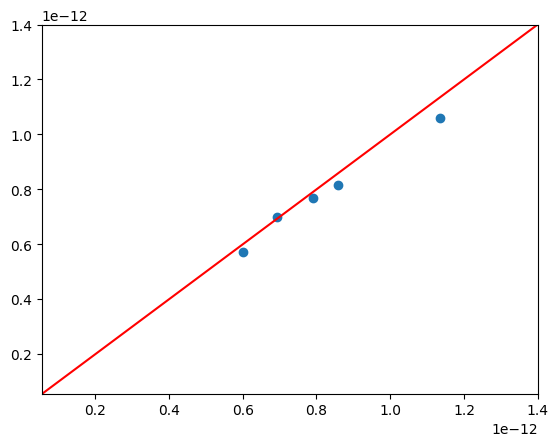

In [12]:
plt.plot(merged_df["Sum Fluxes"], merged_df["Flux_slit"], "o")
# Create a plot
plt.plot(x, y, label='Identity Line', color='red')
plt.xlim(0.55e-13, 14e-13)
plt.ylim(0.55e-13, 14e-13)

# Only the Halpha and [N II] lines

In [13]:
# Spectra VLT
table_spec = Table.read("../flux-halpha-Nii.ecsv", format="ascii.ecsv")

In [14]:
table_spec

Extension Name,Wl mean,Fluxes
str10,float64,float64
SMC-SMP-1,6566.586666666667,5.984076963273202e-13
SMC-SMP-2,6566.586666666667,5.411585907230613e-13
SMC-SMP-8,6566.586666666667,4.852685943849795e-13
SMC-SMP-13,6566.586666666667,8.578245477687001e-13
SMC-SMP-18,6566.586666666667,7.894196143150355e-13
SMC-SMP-20,6566.586666666667,1.1316977042869106e-12
SMC-SMP-24,6566.586666666667,6.920642297568457e-13
SMC-SMP-25,6566.586666666667,2.103127193781976e-13


In [15]:
df3 = table_spec.to_pandas()

In [16]:
# Merge DataFrames on common columns
merged_df3 = pd.merge(df3, df2, left_on='Extension Name', right_on='FileID', how='inner')

In [17]:
merged_df3

,Extension Name,Wl mean,Fluxes,ID,FileID,Flux_slit
0,SMC-SMP-1,6566.586667,5.984077e-13,iDR4_3_MC0113_0054489,SMC-SMP-1,5.720376e-13
1,SMC-SMP-2,6566.586667,5.411586e-13,iDR4_3_MC0093_0237121,SMC-SMP-2,5.614099e-13
2,SMC-SMP-13,6566.586667,8.578245e-13,iDR4_3_MC0115_1053289,SMC-SMP-13,8.170498e-13
3,SMC-SMP-18,6566.586667,7.894196e-13,iDR4_3_MC0115_0671498,SMC-SMP-18,7.686083e-13
4,SMC-SMP-20,6566.586667,1.131698e-12,iDR4_3_MC0048_0001615,SMC-SMP-20,1.061360e-12
5,SMC-SMP-24,6566.586667,6.920642e-13,iDR4_3_MC0094_0183910,SMC-SMP-24,7.005829e-13
6,SMC-SMP-25,6566.586667,2.103127e-13,iDR4_3_MC0094_0213041,SMC-SMP-25,2.038957e-13


Text(0, 0.5, 'F_splus(H$\\alpha$ + [NII])')

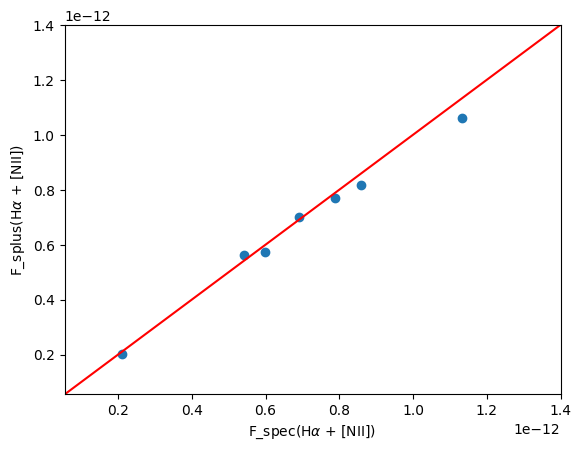

In [18]:
plt.plot(merged_df3["Fluxes"], merged_df3["Flux_slit"], "o")
# Create a plot
plt.plot(x, y, label='Identity Line', color='red')
plt.xlim(0.55e-13, 14e-13)
plt.ylim(0.55e-13, 14e-13)
plt.xlabel(r'F_spec(H$\alpha$ + [NII])')
plt.ylabel(r'F_splus(H$\alpha$ + [NII])')

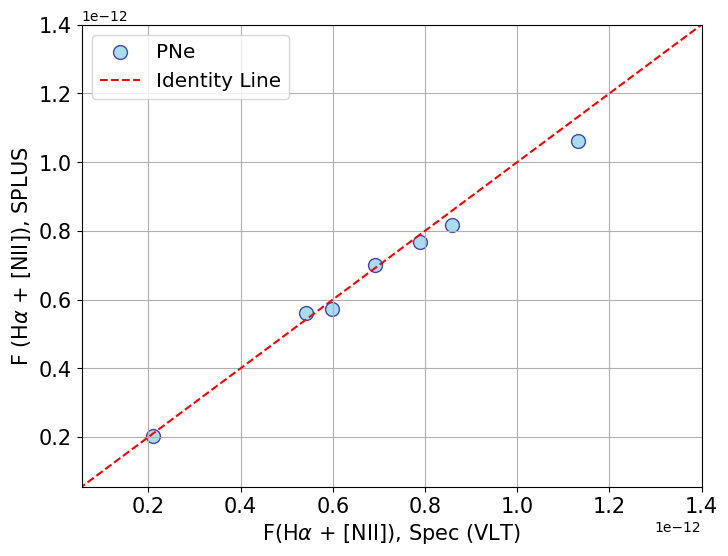

In [33]:

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(
    merged_df3["Fluxes"], merged_df3["Flux_slit"],
    color='skyblue',
    edgecolors='darkblue',
    alpha=0.7,  # Set transparency
    s=100,  # Set marker size
    label='PNe',
)


# Add the identity line (y = x)
plt.plot([-3, 3], [-3, 3], color='red', linestyle='--', label='Identity Line')

# Set labels and title
plt.xlabel(r'F(H$\alpha$ + [NII]), Spec (VLT)',  fontsize=15)
plt.ylabel(r'F (H$\alpha$ + [NII]), SPLUS',  fontsize=15)
plt.xlim(0.55e-13, 14e-13)
plt.ylim(0.55e-13, 14e-13)
#plt.title('Comparison of Two Measurements')
plt.tick_params(axis='x', labelsize=15) 
plt.tick_params(axis='y', labelsize=15)

# Add legend
plt.legend(fontsize="x-large")

# Show plot
plt.grid(True)
plt.show()